#Testando o modelo Arima

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.tsa.stattools import adfuller
import numpy as np

!git clone https://github.com/LuFaiotto/tech-challenge.git

fatal: destination path 'tech-challenge' already exists and is not an empty directory.


# Data Frame 1

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- Resultados da Previsão de Direção (Treino) ---
Acurácia do Modelo (Subir/Descer) no Treino: 58.13%

Iniciando validação Walk-Forward para previsões de Teste...
Validação concluída.

--- Resultados da Previsão de Direção (Teste) ---
Acurácia do Modelo (Subir/Descer) no Teste: 57.32%

Relatório de Classificação (Teste):
                   precision    recall  f1-score   support

Descer/Manter (0)       0.53      0.98      0.69       191
        Subir (1)       0.93      0.20      0.33       212

         accuracy                           0.57       403
        macro avg       0.73      0.59      0.51       403
     weighted avg       0.74      0.57      0.50       403


Matriz de Confusão (Teste):
[[188   3]
 [169  43]]


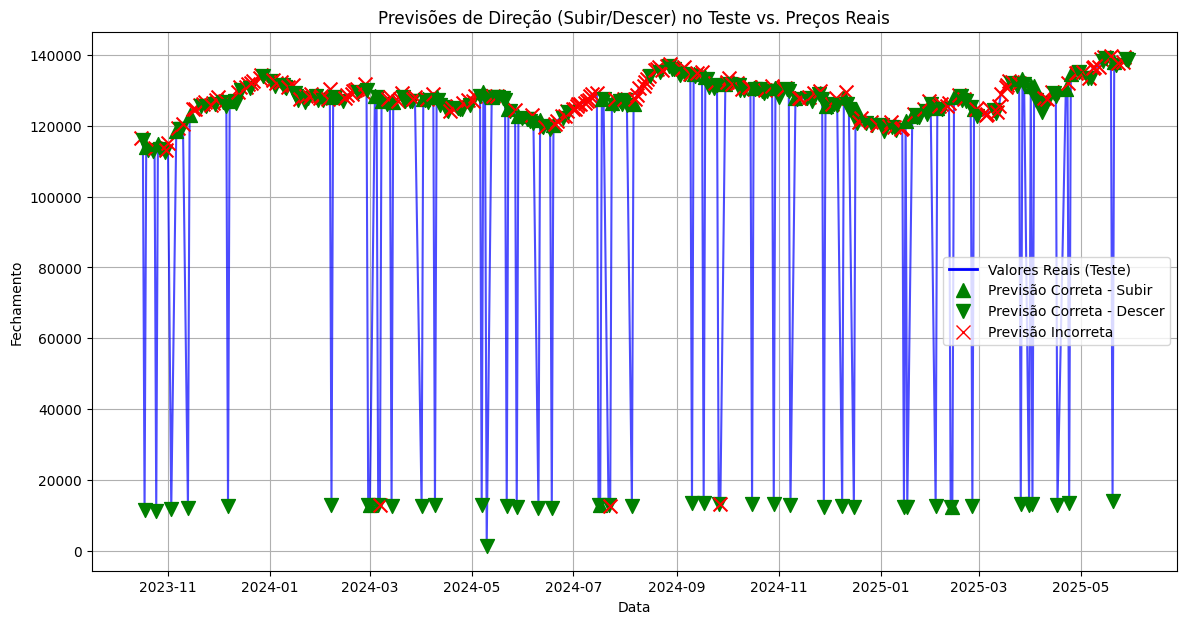

In [13]:
df = pd.read_csv('/content/tech-challenge/Fase_2/Exportacao_Ajustada/Ibovespa_02-01-2020_a_30-05-2025_ajustado.csv')


df['Data'] = pd.to_datetime(df['Data'])
df.set_index('Data', inplace=True)
ts = df['Fechamento']

# Filtrar zeros (potencialmente de fins de semana ou dias não-úteis)
ts = ts[ts != 0]

df_temp = pd.DataFrame(ts)
df_temp['Proximo_Fechamento'] = df_temp['Fechamento'].shift(-1)
df_temp['Direcao_Real'] = (df_temp['Proximo_Fechamento'] > df_temp['Fechamento']).astype(int)
df_temp.dropna(inplace=True) # Remove a última linha que terá NaN em 'Proximo_Fechamento'

# Atualiza a série temporal para a análise, considerando apenas os dados com direção real calculada
ts_directional = df_temp['Fechamento']
true_directions = df_temp['Direcao_Real']


# Definição dos Parâmetros ARIMA

p, d, q = 1, 1, 1

# Treinamento e Previsão

train_size = int(len(ts_directional) * 0.7)
train_data_ts = ts_directional[0:train_size]
test_data_ts = ts_directional[train_size:]
test_true_directions = true_directions[train_size:]

# Previsões de Treino

train_predicted_directions = []
train_actual_directions = []

if len(train_data_ts) > 1: # Precisa de pelo menos 2 pontos para calcular direção
    # Treina o modelo com TODOS os dados de treino
    full_train_model = ARIMA(train_data_ts, order=(p, d, q))
    full_train_model_fit = full_train_model.fit()

    # Previsões de um passo à frente para o conjunto de treino
    # offset=1 para prever o dia seguinte ao último ponto usado na fitting
    train_forecasts = full_train_model_fit.predict(start=0, end=len(train_data_ts) - 1, dynamic=False)


    # Para cada dia no treino (exceto o último, pois não teremos o 'dia seguinte' real)
    for i in range(len(train_data_ts) - 1):
        current_price_train = train_data_ts.iloc[i]
        predicted_next_price_train = train_forecasts.iloc[i] # Previsão para o dia i+1, feita com dados até i

        pred_dir_train = 1 if predicted_next_price_train > current_price_train else 0
        train_predicted_directions.append(pred_dir_train)


        actual_dir_train = true_directions.iloc[i]
        train_actual_directions.append(actual_dir_train)

    if train_actual_directions and train_predicted_directions:
        train_accuracy = accuracy_score(train_actual_directions, train_predicted_directions) * 100
        print(f'\n--- Resultados da Previsão de Direção (Treino) ---')
        print(f'Acurácia do Modelo (Subir/Descer) no Treino: {train_accuracy:.2f}%')

    else:
        print("\nDados de treino insuficientes para calcular a acurácia de treino ou previsões vazias.")
else:
    print("\nConjunto de treino muito pequeno para calcular a acurácia de treino (precisa de pelo menos 2 pontos).")


# Previsões de Teste
history_ts = [x for x in train_data_ts] # Histórico começa com os dados de treino
test_predicted_directions = []
test_actual_directions = []


print("\nIniciando validação Walk-Forward para previsões de Teste...")
# Itera sobre os dados de teste, mas até o penúltimo elemento para ter o próximo preço real
for i in range(len(test_data_ts) - 1):
    current_price_test = test_data_ts.iloc[i] # O preço atual no loop de teste

    # Treina o modelo ARIMA com o histórico atualizado
    # 'history_ts' inclui dados de treino e os dados reais já observados no teste
    model = ARIMA(history_ts, order=(p, d, q))
    model_fit = model.fit()

    # Prever o preço do dia seguinte
    forecast_price = model_fit.forecast(steps=1)[0]

    # Determinar a direção prevista: 1 (subir) se a previsão for maior que o preço atual, 0 (descer/manter) caso contrário
    direction_pred_test = 1 if forecast_price > current_price_test else 0
    test_predicted_directions.append(direction_pred_test)

    actual_direction_test = test_true_directions.iloc[i]
    test_actual_directions.append(actual_direction_test)

    # Adicionar o valor real do dia atual do conjunto de teste ao histórico para a próxima iteração
    history_ts.append(current_price_test)

print("Validação concluída.")


# Avaliação da Acurácia da Direção no Teste

if not test_actual_directions:
    print("\nNão há previsões suficientes para calcular a acurácia no teste. Verifique o tamanho dos seus dados de teste.")
else:
    test_accuracy = accuracy_score(test_actual_directions, test_predicted_directions) * 100
    print(f'\n--- Resultados da Previsão de Direção (Teste) ---')
    print(f'Acurácia do Modelo (Subir/Descer) no Teste: {test_accuracy:.2f}%')

    print('\nRelatório de Classificação (Teste):')
    print(classification_report(test_actual_directions, test_predicted_directions, target_names=['Descer/Manter (0)', 'Subir (1)']))

    print('\nMatriz de Confusão (Teste):')
    print(confusion_matrix(test_actual_directions, test_predicted_directions))

    # Plotar as direções reais vs. previstas (para o conjunto de teste)
    plt.figure(figsize=(14, 7))
    plt.plot(test_data_ts.index[1:len(test_actual_directions)+1], test_data_ts.iloc[1:len(test_actual_directions)+1], label='Valores Reais de Fechamento (Teste)', color='blue', alpha=0.7)

    for j in range(len(test_actual_directions)):
        idx = test_data_ts.index[j + 1] # O índice real da data para o preço que gerou a direção
        actual_price = test_data_ts.iloc[j + 1] # O preço real do dia que estamos prevendo a direção

        pred_dir = test_predicted_directions[j]
        actual_dir = test_actual_directions[j]

        if pred_dir == actual_dir: # Previsão correta
            color = 'green'
            marker = '^' if pred_dir == 1 else 'v' # Seta para cima se previu subir, para baixo se previu descer
        else: # Previsão incorreta
            color = 'red'
            marker = 'x' # Marca X para erro

        plt.scatter(idx, actual_price, color=color, marker=marker, s=100, zorder=5)

    plt.title('Previsões de Direção (Subir/Descer) no Teste vs. Preços Reais')
    plt.xlabel('Data')
    plt.ylabel('Fechamento')

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='blue', lw=2, label='Valores Reais (Teste)'),
                    Line2D([0], [0], marker='^', color='green', markersize=10, linestyle='None', label='Previsão Correta - Subir'),
                    Line2D([0], [0], marker='v', color='green', markersize=10, linestyle='None', label='Previsão Correta - Descer'),
                    Line2D([0], [0], marker='x', color='red', markersize=10, linestyle='None', label='Previsão Incorreta')]
    plt.legend(handles=custom_lines)

    plt.grid(True)
    plt.show()

# Data Frame 2

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- Resultados da Previsão de Direção (Treino) ---
Acurácia do Modelo (Subir/Descer) no Treino: 58.13%

Iniciando validação Walk-Forward para previsões de Teste...
Validação Walk-Forward concluída.

--- Resultados da Previsão de Direção (Teste) ---
Acurácia do Modelo (Subir/Descer) no Teste: 57.32%

Relatório de Classificação (Teste):
                   precision    recall  f1-score   support

Descer/Manter (0)       0.53      0.98      0.69       191
        Subir (1)       0.93      0.20      0.33       212

         accuracy                           0.57       403
        macro avg       0.73      0.59      0.51       403
     weighted avg       0.74      0.57      0.50       403


Matriz de Confusão (Teste):
[[188   3]
 [169  43]]


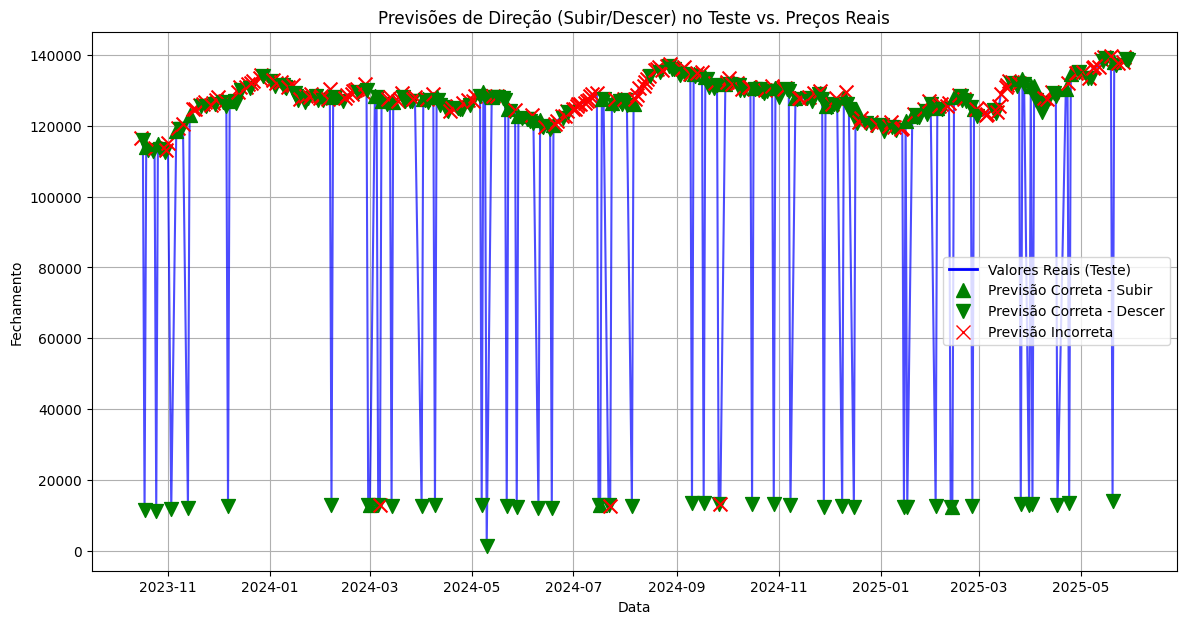

In [14]:
df_2 = pd.read_csv('/content/tech-challenge/Fase_2/Exportacao_Ajustada/Ibovespa_02-01-2020_a_01-07-2025_ajustado.csv')


df_2['Data'] = pd.to_datetime(df_2['Data'])
df_2.set_index('Data', inplace=True)


ts = df['Fechamento']

ts = ts[ts != 0]


df_temp = pd.DataFrame(ts)
df_temp['Proximo_Fechamento'] = df_temp['Fechamento'].shift(-1)
df_temp['Direcao_Real'] = (df_temp['Proximo_Fechamento'] > df_temp['Fechamento']).astype(int)
df_temp.dropna(inplace=True)


ts_directional = df_temp['Fechamento']
true_directions = df_temp['Direcao_Real']



p, d, q = 1, 1, 1



train_size = int(len(ts_directional) * 0.7)
train_data_ts = ts_directional[0:train_size]
test_data_ts = ts_directional[train_size:]
test_true_directions = true_directions[train_size:]

train_predicted_directions = []
train_actual_directions = []

if len(train_data_ts) > 1:

    full_train_model = ARIMA(train_data_ts, order=(p, d, q))
    full_train_model_fit = full_train_model.fit()


    train_forecasts = full_train_model_fit.predict(start=0, end=len(train_data_ts) - 1, dynamic=False)


    for i in range(len(train_data_ts) - 1):
        current_price_train = train_data_ts.iloc[i]
        predicted_next_price_train = train_forecasts.iloc[i]

        pred_dir_train = 1 if predicted_next_price_train > current_price_train else 0
        train_predicted_directions.append(pred_dir_train)


        actual_dir_train = true_directions.iloc[i]
        train_actual_directions.append(actual_dir_train)

    if train_actual_directions and train_predicted_directions:
        train_accuracy = accuracy_score(train_actual_directions, train_predicted_directions) * 100
        print(f'\n--- Resultados da Previsão de Direção (Treino) ---')
        print(f'Acurácia do Modelo (Subir/Descer) no Treino: {train_accuracy:.2f}%')
    else:
        print("\nDados de treino insuficientes para calcular a acurácia de treino ou previsões vazias.")
else:
    print("\nConjunto de treino muito pequeno para calcular a acurácia de treino (precisa de pelo menos 2 pontos).")


history_ts = [x for x in train_data_ts]
test_predicted_directions = []
test_actual_directions = []


print("\nIniciando validação para previsões de Teste...")

for i in range(len(test_data_ts) - 1):
    current_price_test = test_data_ts.iloc[i]

    model = ARIMA(history_ts, order=(p, d, q))
    model_fit = model.fit()


    forecast_price = model_fit.forecast(steps=1)[0]


    direction_pred_test = 1 if forecast_price > current_price_test else 0
    test_predicted_directions.append(direction_pred_test)


    actual_direction_test = test_true_directions.iloc[i]
    test_actual_directions.append(actual_direction_test)


    history_ts.append(current_price_test)

print("Validação concluída.")

if not test_actual_directions:
    print("\nNão há previsões suficientes para calcular a acurácia no teste. Verifique o tamanho dos seus dados de teste.")
else:
    test_accuracy = accuracy_score(test_actual_directions, test_predicted_directions) * 100
    print(f'\n--- Resultados da Previsão de Direção (Teste) ---')
    print(f'Acurácia do Modelo (Subir/Descer) no Teste: {test_accuracy:.2f}%')

    print('\nRelatório de Classificação (Teste):')
    print(classification_report(test_actual_directions, test_predicted_directions, target_names=['Descer/Manter (0)', 'Subir (1)']))

    print('\nMatriz de Confusão (Teste):')
    print(confusion_matrix(test_actual_directions, test_predicted_directions))


    plt.figure(figsize=(14, 7))
    plt.plot(test_data_ts.index[1:len(test_actual_directions)+1], test_data_ts.iloc[1:len(test_actual_directions)+1], label='Valores Reais de Fechamento (Teste)', color='blue', alpha=0.7)

    for j in range(len(test_actual_directions)):
        idx = test_data_ts.index[j + 1]
        actual_price = test_data_ts.iloc[j + 1]

        pred_dir = test_predicted_directions[j]
        actual_dir = test_actual_directions[j]

        if pred_dir == actual_dir:
            color = 'green'
            marker = '^' if pred_dir == 1 else 'v'
        else:
            color = 'red'
            marker = 'x'

        plt.scatter(idx, actual_price, color=color, marker=marker, s=100, zorder=5)

    plt.title('Previsões de Direção (Subir/Descer) no Teste vs. Preços Reais')
    plt.xlabel('Data')
    plt.ylabel('Fechamento')

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='blue', lw=2, label='Valores Reais (Teste)'),
                    Line2D([0], [0], marker='^', color='green', markersize=10, linestyle='None', label='Previsão Correta - Subir'),
                    Line2D([0], [0], marker='v', color='green', markersize=10, linestyle='None', label='Previsão Correta - Descer'),
                    Line2D([0], [0], marker='x', color='red', markersize=10, linestyle='None', label='Previsão Incorreta')]
    plt.legend(handles=custom_lines)

    plt.grid(True)
    plt.show()